In [2]:
import tensorflow as tf
#import tensorflow.compat.v1 as tf
#tf.disable_v2_behavior()

from matplotlib import pyplot as plt
from matplotlib import image
%matplotlib inline 
import numpy as np
import PIL
import skimage as ski
# We will use opencv
import cv2
import imutils
from imutils import object_detection
import random

#from tensorflow.compat.v1.keras.models import load_model
from tensorflow.keras.models import load_model

# Train local TF version

In [3]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

In [2]:
(X_train_o, y_train_o), (X_test_o, y_test_o) = tf.keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 185s 1us/step


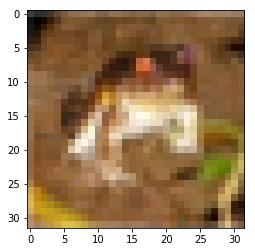

In [4]:
plt.imshow(X_train_o[0])

In [17]:
def convertGrayScaleAndMnistSize(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return ski.transform.resize(gray, (28, 28), anti_aliasing=True)

In [60]:
X_train_o_t = (255 * np.array(list(map(convertGrayScaleAndMnistSize, X_train_o)))).astype(np.uint8)

In [61]:
X_test_o_t = (255 * np.array(list(map(convertGrayScaleAndMnistSize, X_test_o)))).astype(np.uint8)

In [62]:
list_index_datasets = list(range(len(X_train) + len(X_train_o)))
order_mixed_dataset = random.sample(list_index_datasets, len(list_index_datasets))
X_train_tt = np.concatenate((X_train, X_train_o_t))[order_mixed_dataset]
y_train_tt = np.concatenate((y_train, 10 * np.ones(len(y_train)).astype(np.uint8)))[order_mixed_dataset]

In [63]:
list_index_datasets = list(range(len(X_test) + len(X_test_o)))
order_mixed_dataset = random.sample(list_index_datasets, len(list_index_datasets))
X_test_tt = np.concatenate((X_test, X_test_o_t))[order_mixed_dataset]
y_test_tt = np.concatenate((y_test, 10 * np.ones(len(y_test)).astype(np.uint8)))[order_mixed_dataset]

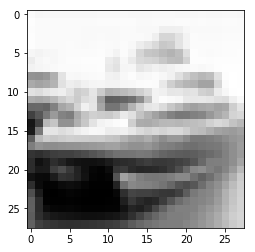

In [31]:
plt.imshow(X_test_o_t[1], cmap='gray')

In [64]:
X_valid, X_train = X_train_tt[:5000], X_train_tt[5000:]
y_valid, y_train = y_train_tt[:5000], y_train_tt[5000:]
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)
input_shape = (28, 28, 1)
# Making sure that the values are float so that we can get decimal points after division
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
# Normalizing the RGB codes by dividing it to the max RGB value.
X_train /= 255
X_test /= 255

In [20]:
# X_valid, X_train = X_train[:5000], X_train[5000:]
# y_valid, y_train = y_train[:5000], y_train[5000:]
# X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
# X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)
# input_shape = (28, 28, 1)
# # Making sure that the values are float so that we can get decimal points after division
# X_train = X_train.astype('float32')
# X_test = X_test.astype('float32')
# # Normalizing the RGB codes by dividing it to the max RGB value.
# X_train /= 255
# X_test /= 255

In [65]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D

In [68]:
input_shape = (28, 28, 1)

# Creating a Sequential Model and adding the layers
model = Sequential()
model.add(Conv2D(28, kernel_size=(3,3), input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten()) # Flattening the 2D arrays for fully connected layers
model.add(Dense(128, activation=tf.nn.relu))
model.add(Dropout(0.2))
model.add(Dense(11, activation=tf.nn.softmax))
#model.add(Dense(10, activation=tf.nn.softmax))

In [69]:
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])
model.fit(x=X_train,y=y_train, epochs=10)

Epoch 1/10
105000/105000 [==============================] - 83s 786us/step - loss: 0.1203 - acc: 0.9640
Epoch 2/10
105000/105000 [==============================] - 81s 769us/step - loss: 0.0479 - acc: 0.9851
Epoch 3/10
105000/105000 [==============================] - 84s 799us/step - loss: 0.0336 - acc: 0.9894
Epoch 4/10
105000/105000 [==============================] - 86s 817us/step - loss: 0.0245 - acc: 0.9918
Epoch 5/10
105000/105000 [==============================] - 89s 852us/step - loss: 0.0200 - acc: 0.9934
Epoch 6/10
105000/105000 [==============================] - 85s 811us/step - loss: 0.0175 - acc: 0.9939
Epoch 7/10
105000/105000 [==============================] - 83s 793us/step - loss: 0.0148 - acc: 0.9951
Epoch 8/10
105000/105000 [==============================] - 87s 829us/step - loss: 0.0146 - acc: 0.9951
Epoch 9/10
105000/105000 [==============================] - 101s 959us/step - loss: 0.0120 - acc: 0.9959
Epoch 10/10
105000/105000 [==============================] - 13

In [11]:
model.save("./cnn_model_11.h5")
# #model.save("./cnn_model.h5")

# Real-time predictor

In [3]:
def padwithtens(vector, pad_width, iaxis, kwargs):
    vector[:pad_width[0]] = 0
    vector[-pad_width[1]:] = 0
    return vector

def mnistTransformation(image, angle_rotation):
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    thresh = ski.filters.threshold_otsu(image)
    image = 255 * np.where(image < thresh, (1 - image), 0).astype(np.uint8)
    (x, y, w, h) = cv2.boundingRect(image) 
    image = image[y : y + h, x: x + w]
    image = ski.util.pad(image, int(0.35 * max(image.shape)), padwithtens)
    if angle_rotation:
        image = ski.transform.rotate(image, angle_rotation)
    image = ski.transform.resize(image, (28, 28), anti_aliasing=True)
    image = ski.restoration.denoise_tv_chambolle(image, 1e-2)
    image = 255 * image / image.max()
    return image

def fromPathMnistTrasformation(im_path, angle_rotation=None):
    #image =  cv2.imread(im_path)
    image = ski.io.imread(im_path)
    return  mnistTransformation(image, angle_rotation)

def fromImageMnistTrasformation(image, angle_rotation=None):
    return  mnistTransformation(image, angle_rotation)    

# def filterSubDigits(digits):
#     max_x = max(digit[0].shape[0] for digit in digits)
#     max_y = max(digit[0].shape[1] for digit in digits)
    
#     p_25_x = np.percentile([digit[0].shape[0] for digit in digits], 10) 
#     p_75_x = np.percentile([digit[0].shape[0] for digit in digits], 90) 
#     p_25_y = np.percentile([digit[0].shape[1] for digit in digits], 10) 
#     p_75_y = np.percentile([digit[0].shape[1] for digit in digits], 90) 
    
#     return [digit for digit in digits if p_75_x > digit[0].shape[0] > p_25_x and p_75_y > digit[0].shape[1] > p_25_y]

def filterBestCandidates(cnts, image_color_s, image_):
    
    valid_boxes = []
    scores = []
    
    for c in cnts:
        (x, y, w, h) = cv2.boundingRect(c)
        roi = image_[y - n_pad : y + h + n_pad, x - n_pad : x + w + n_pad]
    
        try:
            roi_tr = fromImageMnistTrasformation(roi)
            pred_score = loaded_model.predict(roi_tr.reshape(1, 28, 28, 1) / 255).max()
            
            valid_boxes.append((x - n_pad, y - n_pad, x + w + n_pad, y + h + n_pad))
            scores.append(pred_score)
            
        except:
            pass
        
    boxes = object_detection.non_max_suppression(np.array(valid_boxes), probs=np.array(scores), overlapThresh=0.01)
    #boxes = np.array(valid_boxes)
    
    for (startX, startY, endX, endY) in boxes:
        
        try:
        
            roi = image_[startY : endY, startX : endX]
            roi_tr = fromImageMnistTrasformation(roi)
            pred_digit = loaded_model.predict(roi_tr.reshape(1, 28, 28, 1) / 255).argmax()

            cv2.rectangle(image_color_s, (startX, startY), (endX, endY), (57, 255, 20), 2)
            cv2.putText(image_color_s, str(pred_digit), (endX, endY), 0, 0.7, (57, 255, 20), 1)
            
        except:
            
            pass
        
    return image_color_s

In [4]:
loaded_model = load_model("./cnn_model.h5")
#loaded_model = load_model("./cnn_model_11.h5")
n_pad = 0

## Text recognition

In [6]:
def digitsDetector(image_color):
    
    image_color_s = imutils.resize(image_color, width=min(300, image_color.shape[1]))
    image_ = cv2.cvtColor(image_color_s, cv2.COLOR_BGR2GRAY)
    blurred = 255 * ski.restoration.denoise_tv_chambolle(image_, 1e-1)
    edged = cv2.Canny(blurred.astype(np.uint8), 100, 200)
    cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    
    return edged#filterBestCandidates(cnts, image_color_s, image_)
    
#     rois = []
#     for c in cnts:
#         # extract the digit ROI
#         (x, y, w, h) = cv2.boundingRect(c)
#         rois.append([image_[y - n_pad : y + h + n_pad, x - n_pad : x + w + n_pad],
#                      (x, y, w, h)])
        
#     #for roi, (x, y, w, h) in filterSubDigits(rois):
#     for roi, (x, y, w, h) in rois:
                
#         try:
#             roi_tr = fromImageMnistTrasformation(roi)
#             pred = loaded_model.predict(roi_tr.reshape(1, 28, 28, 1) / 255)
            
#             cv2.rectangle(image_color_s, (x, y), (x + w, y + h), (0, 255, 0), 2)
#             cv2.putText(image_color_s, str(pred.argmax()), (x + int(0.25 * w), y + int(1.5 * h)), 0, 0.7, (57, 255, 20), 1)
            
#         except:
#             pass
            

#     return image_color_s

In [7]:
a = 0
video = cv2.VideoCapture(0)

while True:
    
    a += 1
    check, frame = video.read()

    print(check)
    print(frame)

    cv2.imshow("Capturing", digitsDetector(frame))
    
    key = cv2.waitKey(1)
    
    if key == ord('q'):
        break

video.release()

cv2.destroyAllWindows()

True
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]
True
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]
True
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
 

In [25]:
video.release()

cv2.destroyAllWindows()

## Text detection

In [51]:
image_ = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
#image_ = cv2.resize(image_, (320, 320))

In [101]:
frame.shape

(480, 640, 3)

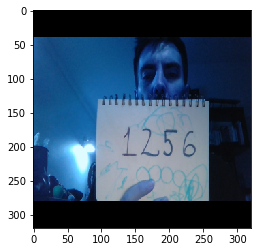

In [52]:
inpHeight, inpWidth = image_.shape
image_ = cv2.resize(frame, (320, 320))
plt.imshow(image_, cmap='gray')

In [45]:
# OpenCV’s EAST text detector is a deep learning model, based on a novel architecture and training pattern. 
# It is capable of (1) running at near real-time at 13 FPS on 720p images and (2) 
# obtains state-of-the-art text detection accuracy.
# We call the algorithm “EAST” because it’s an: Efficient and Accurate Scene Text detection pipeline.
net = cv2.dnn.readNet('./frozen_east_text_detection.pb')

In [95]:
# This method creates 4-dimensional blob from input images. It's the input of the EAST neural network
blob = cv2.dnn.blobFromImage(image_, 1.0, (320, 320), (123.68, 116.78, 103.94), True, False)

In [96]:
outputLayers = []
outputLayers.append("feature_fusion/Conv_7/Sigmoid")
outputLayers.append("feature_fusion/concat_3")

In [97]:
net.setInput(blob)
output = net.forward(outputLayers)
 
scores = output[0]
geometry = output[1]

In [98]:
# grab the number of rows and columns from the scores volume, then
# initialize our set of bounding box rectangles and corresponding
# confidence scores
(numRows, numCols) = scores.shape[2:4]
min_confidence = 0.9
rects = []
confidences = []
# loop over the number of rows
for y in range(0, numRows):
    # extract the scores (probabilities), followed by the geometrical
    # data used to derive potential bounding box coordinates that
    # surround text
    scoresData = scores[0, 0, y]
    xData0 = geometry[0, 0, y]
    xData1 = geometry[0, 1, y]
    xData2 = geometry[0, 2, y]
    xData3 = geometry[0, 3, y]
    anglesData = geometry[0, 4, y]
    
# loop over the number of columns
    for x in range(0, numCols):
        # if our score does not have sufficient probability, ignore it
        if scoresData[x] < min_confidence:
            continue
        # compute the offset factor as our resulting feature maps will
        # be 4x smaller than the input image
        (offsetX, offsetY) = (x * 4.0, y * 4.0)
        # extract the rotation angle for the prediction and then
        # compute the sin and cosine
        angle = anglesData[x]
        cos = np.cos(angle)
        sin = np.sin(angle)
        # use the geometry volume to derive the width and height of
        # the bounding box
        h = xData0[x] + xData2[x]
        w = xData1[x] + xData3[x]
        # compute both the starting and ending (x, y)-coordinates for
        # the text prediction bounding box
        endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
        endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
        startX = int(endX - w)
        startY = int(endY - h)
        # add the bounding box coordinates and probability score to
        # our respective lists
        rects.append((startX, startY, endX, endY))
        confidences.append(scoresData[x])

In [99]:
# apply non-maxima suppression to suppress weak, overlapping bounding
# boxes
boxes = object_detection.non_max_suppression(np.array(rects), probs=confidences, overlapThresh=0.3)
# loop over the bounding boxes

rW = inpWidth / 320
rH = inpHeight / 320

orig = frame.copy()

for (startX, startY, endX, endY) in boxes:
    # scale the bounding box coordinates based on the respective
    # ratios
    startX = int(startX * rW)
    startY = int(startY * rH)
    endX = int(endX * rW)
    endY = int(endY * rH)
    # draw the bounding box on the image
    cv2.rectangle(orig, (startX, startY), (endX, endY), (0, 255, 0), 2)

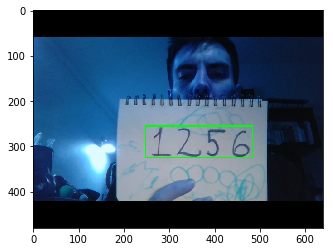

In [100]:
plt.imshow(orig)

In [116]:
net = cv2.dnn.readNet('./frozen_east_text_detection.pb')
outputLayers = []
outputLayers.append("feature_fusion/Conv_7/Sigmoid")
outputLayers.append("feature_fusion/concat_3")

def textDetection(color_image):
    
    
    inpHeight, inpWidth = color_image.shape[:2]
    image_ = cv2.resize(color_image, (320, 320))
    blob = cv2.dnn.blobFromImage(image_, 1.0, (320, 320), (123.68, 116.78, 103.94), True, False)
    
    net.setInput(blob)
    output = net.forward(outputLayers)
 
    scores = output[0]
    geometry = output[1]
    
    # grab the number of rows and columns from the scores volume, then
    # initialize our set of bounding box rectangles and corresponding
    # confidence scores
    (numRows, numCols) = scores.shape[2:4]
    min_confidence = 0.5
    rects = []
    confidences = []
    # loop over the number of rows
    for y in range(0, numRows):
        # extract the scores (probabilities), followed by the geometrical
        # data used to derive potential bounding box coordinates that
        # surround text
        scoresData = scores[0, 0, y]
        xData0 = geometry[0, 0, y]
        xData1 = geometry[0, 1, y]
        xData2 = geometry[0, 2, y]
        xData3 = geometry[0, 3, y]
        anglesData = geometry[0, 4, y]

    # loop over the number of columns
        for x in range(0, numCols):
            # if our score does not have sufficient probability, ignore it
            if scoresData[x] < min_confidence:
                continue
            # compute the offset factor as our resulting feature maps will
            # be 4x smaller than the input image
            (offsetX, offsetY) = (x * 4.0, y * 4.0)
            # extract the rotation angle for the prediction and then
            # compute the sin and cosine
            angle = anglesData[x]
            cos = np.cos(angle)
            sin = np.sin(angle)
            # use the geometry volume to derive the width and height of
            # the bounding box
            h = xData0[x] + xData2[x]
            w = xData1[x] + xData3[x]
            # compute both the starting and ending (x, y)-coordinates for
            # the text prediction bounding box
            endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
            endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
            startX = int(endX - w)
            startY = int(endY - h)
            # add the bounding box coordinates and probability score to
            # our respective lists
            rects.append((startX, startY, endX, endY))
            confidences.append(scoresData[x])
            
    # apply non-maxima suppression to suppress weak, overlapping bounding
    # boxes
    boxes = object_detection.non_max_suppression(np.array(rects), probs=confidences, overlapThresh=0.3)
    # loop over the bounding boxes

    rW = inpWidth / 320
    rH = inpHeight / 320

    orig = color_image.copy()
    scaled_boxes = []

    for (startX, startY, endX, endY) in boxes:
        # scale the bounding box coordinates based on the respective
        # ratios
        startX = int(startX * rW)
        startY = int(startY * rH)
        endX = int(endX * rW)
        endY = int(endY * rH)
        # draw the bounding box on the image
        cv2.rectangle(orig, (startX, startY), (endX, endY), (57, 255, 20), 2)
        scaled_boxes.append((startX, startY, endX, endY))
        
    return orig, scaled_boxes